# TorchVision Instance Segmentation Finetuning Tutorial

For this tutorial, we will be finetuning a pre-trained [Mask R-CNN](https://arxiv.org/abs/1703.06870) model in the [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/). It contains 170 images with 345 instances of pedestrians, and we will use it to illustrate how to use the new features in torchvision in order to train an instance segmentation model on a custom dataset.

First, we need to install `pycocotools`. This library will be used for computing the evaluation metrics following the COCO metric for intersection over union.

In [4]:
%%shell

pip install cython xmltodict
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-589sn1kn
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-589sn1kn


In [20]:
%%shell

rm -rf MoNuSeg/
rm -rf ML-Unsupervised/
git clone -b Segmentation-ModelTraining https://github.com/Digital-Pathology/ML-Unsupervised.git
cp -r ML-Unsupervised/Datasets/MoNuSeg/ MoNuSeg/

Cloning into 'ML-Unsupervised'...
remote: Enumerating objects: 449, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 449 (delta 107), reused 409 (delta 70), pack-reused 0
Receiving objects: 100% (449/449), 253.95 MiB | 26.57 MiB/s, done.
Resolving deltas: 100% (107/107), done.
Checking out files: 100% (208/208), done.


In [3]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.


One note on the labels. The model considers class 0 as background. If your dataset does not contain the background class, you should not have 0 in your labels. For example, assuming you have just two classes, cat and dog, you can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has both classes, your labels tensor should look like [1,2].

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


So each image has a corresponding segmentation mask, where each color correspond to a different instance. Let's write a `torch.utils.data.Dataset` class for this dataset.

In [24]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import MoNuSeg


class NotPennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = MoNuSeg.FileReader.files[:]

    def __getitem__(self, idx):
        # load images ad masks
        img = MoNuSeg.FileReader.get_image(self.imgs[idx], as_tensor=False).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = np.array(MoNuSeg.FileReader.get_polymask(self.imgs[idx], as_tensor=False))

        # reduce size because G-RAM is limited :(
        N = 512
        img = img.crop((0,0,N,N))
        mask = mask[:-N,:-N]
        #return img, mask

        # instances are encoded as different colors
        obj_ids = np.unique(mask)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = []
        boxes = []
        for obj_id in obj_ids:
          obj_mask = mask == obj_id
          pos = np.where(obj_mask)
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          if abs(xmax-xmin) > 1 and abs(ymax-ymin) > 1:
            masks.append(obj_mask)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(masks),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
dataset = NotPennFudanDataset()

That's all for the dataset. Let's see how the outputs are structured for this dataset

So we can see that by default, the dataset returns a `PIL.Image` and a dictionary
containing several fields, including `boxes`, `labels` and `masks`.

In [25]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [26]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


#### Note that we do not need to add a mean/std normalization nor image rescaling in the data transforms, as those are handled internally by the Mask R-CNN model.

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [33]:
# use our dataset and defined transformations
dataset = NotPennFudanDataset(get_transform(train=True))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cuda


In [47]:
def do_epochs(num_epochs):
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [35]:
# let's train it for 10 epochs
do_epochs(10)

Epoch: [0]  [ 0/10]  eta: 0:06:00  lr: 0.000560  loss: 10.4220 (10.4220)  loss_classifier: 0.8976 (0.8976)  loss_box_reg: 0.5528 (0.5528)  loss_mask: 1.6452 (1.6452)  loss_objectness: 6.9796 (6.9796)  loss_rpn_box_reg: 0.3468 (0.3468)  time: 36.0303  data: 32.7835  max mem: 7435
Epoch: [0]  [ 9/10]  eta: 0:00:13  lr: 0.005000  loss: 3.6745 (5.0919)  loss_classifier: 0.5758 (0.6521)  loss_box_reg: 0.5528 (0.5616)  loss_mask: 1.1455 (1.2449)  loss_objectness: 0.6605 (2.3105)  loss_rpn_box_reg: 0.3468 (0.3229)  time: 13.4689  data: 10.6885  max mem: 7717
Epoch: [0] Total time: 0:02:14 (13.4755 s / it)
Epoch: [1]  [ 0/10]  eta: 0:03:46  lr: 0.005000  loss: 3.2103 (3.2103)  loss_classifier: 0.8270 (0.8270)  loss_box_reg: 0.5108 (0.5108)  loss_mask: 0.6723 (0.6723)  loss_objectness: 0.7720 (0.7720)  loss_rpn_box_reg: 0.4282 (0.4282)  time: 22.6221  data: 19.4656  max mem: 7717
Epoch: [1]  [ 9/10]  eta: 0:00:13  lr: 0.005000  loss: 2.9002 (3.0484)  loss_classifier: 0.5201 (0.6086)  loss_box_r

In [ ]:
do_epochs(20)

Epoch: [0]  [ 0/10]  eta: 0:04:21  lr: 0.000560  loss: 2.7393 (2.7393)  loss_classifier: 0.5124 (0.5124)  loss_box_reg: 0.7408 (0.7408)  loss_mask: 0.5993 (0.5993)  loss_objectness: 0.5355 (0.5355)  loss_rpn_box_reg: 0.3513 (0.3513)  time: 26.1542  data: 23.1132  max mem: 7727
Epoch: [0]  [ 9/10]  eta: 0:00:13  lr: 0.005000  loss: 2.6037 (2.6128)  loss_classifier: 0.5057 (0.5044)  loss_box_reg: 0.6832 (0.6819)  loss_mask: 0.6106 (0.6523)  loss_objectness: 0.4975 (0.4903)  loss_rpn_box_reg: 0.2830 (0.2839)  time: 13.0003  data: 10.2006  max mem: 7727
Epoch: [0] Total time: 0:02:10 (13.0070 s / it)
Epoch: [1]  [ 0/10]  eta: 0:06:25  lr: 0.005000  loss: 2.3929 (2.3929)  loss_classifier: 0.5018 (0.5018)  loss_box_reg: 0.6396 (0.6396)  loss_mask: 0.5442 (0.5442)  loss_objectness: 0.4411 (0.4411)  loss_rpn_box_reg: 0.2663 (0.2663)  time: 38.5278  data: 35.3840  max mem: 7727
Epoch: [1]  [ 9/10]  eta: 0:00:13  lr: 0.005000  loss: 2.5987 (2.6012)  loss_classifier: 0.5006 (0.4981)  loss_box_reg

Now that training has finished, let's have a look at what it actually predicts in a test image

In [41]:
# pick one image from the test set
img, _ = dataset[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [42]:
#prediction

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

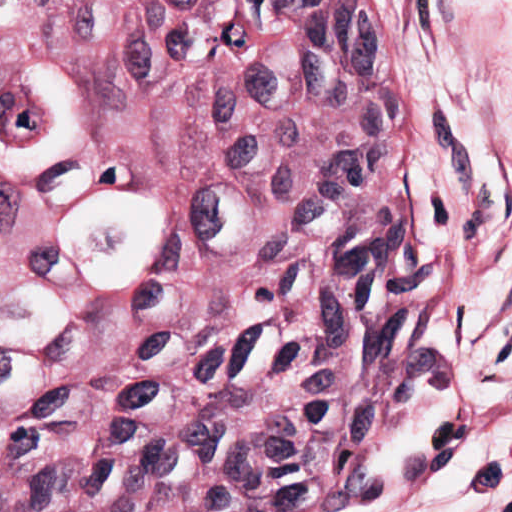

In [43]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

And let's now visualize the top predicted segmentation mask. The masks are predicted as `[N, 1, H, W]`, where `N` is the number of predictions, and are probability maps between 0-1.

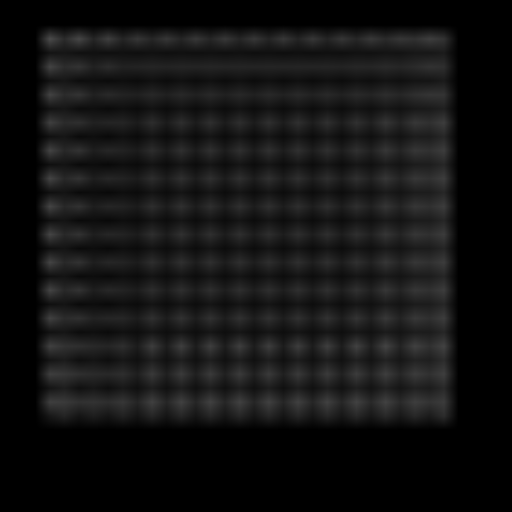

In [46]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

Looks pretty good!

## Wrapping up

In this tutorial, you have learned how to create your own training pipeline for instance segmentation models, on a custom dataset.
For that, you wrote a `torch.utils.data.Dataset` class that returns the images and the ground truth boxes and segmentation masks. You also leveraged a Mask R-CNN model pre-trained on COCO train2017 in order to perform transfer learning on this new dataset.

For a more complete example, which includes multi-machine / multi-gpu training, check `references/detection/train.py`, which is present in the [torchvision GitHub repo](https://github.com/pytorch/vision/tree/v0.8.2/references/detection). 



In [ ]:
import pickle
model_path = "temp.model"
file_write_mode = "w" is os.path.exists(model_path) else "x"
with open(model_path, file_write_mode+"b") as f:
  pickle.dump(model, f)

['.config',
 'vision',
 'coco_eval.py',
 'coco_utils.py',
 'temp.model',
 'transforms.py',
 'ML-Unsupervised',
 '__pycache__',
 'utils.py',
 'engine.py',
 'MoNuSeg',
 'sample_data']

In [36]:
import time
time.sleep(12000)

KeyboardInterrupt: ignored